In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/22 03:37:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Read in dataset
data = spark.read.csv('Dataset/heart_attack_dataset.csv', header=True, inferSchema=True)

## Describe the data

In [3]:
data.printSchema()

root
 |-- Patient ID: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- Systolic: integer (nullable = true)
 |-- Diastolic : integer (nullable = true)
 |-- Heart Rate: integer (nullable = true)
 |-- Diabetes: integer (nullable = true)
 |-- Family History (1: Yes): integer (nullable = true)
 |-- Smoking: integer (nullable = true)
 |-- Obesity: integer (nullable = true)
 |-- Alcohol Consumption: integer (nullable = true)
 |-- Exercise Hours Per Week: double (nullable = true)
 |-- Diet: string (nullable = true)
 |-- Previous Heart Problems (1 : Yes): integer (nullable = true)
 |-- Medication Use: integer (nullable = true)
 |-- Stress Level: integer (nullable = true)
 |-- Sedentary Hours Per Day: double (nullable = true)
 |-- Income: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Triglycerides: integer (nullable = true)
 |-- Physical Activity Days Per Week: integer (nullable = 

In [4]:
# Count the number of rows
num_rows = data.count()

# Count the number of columns
num_columns = len(data.columns)

# Print the results
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

Number of rows: 2499
Number of columns: 27


In [5]:
from pyspark.sql.functions import round

selected_columns = ['Age', 'Exercise Hours Per Week', 'Sleep Hours Per Day', 'Income']

summary = data.select(selected_columns).describe()

summary_rounded = summary.select(summary["summary"],
                                 *[round(summary[col], 2).alias(col) for col in selected_columns])


# Show the summary statistics
summary_rounded.show()


+-------+------+-----------------------+-------------------+---------+
|summary|   Age|Exercise Hours Per Week|Sleep Hours Per Day|   Income|
+-------+------+-----------------------+-------------------+---------+
|  count|2499.0|                 2496.0|             2497.0|   2499.0|
|   mean| 53.55|                   9.98|                7.0|157514.21|
| stddev| 21.29|                   5.78|               2.03| 80349.55|
|    min|  18.0|                   0.01|                2.0|   5000.0|
|    max| 103.0|                  40.55|               20.0| 299769.0|
+-------+------+-----------------------+-------------------+---------+



In [6]:
# Perform value counts for the variable "Gender"
value_counts = data.groupBy("Sex").count()

# Show the value counts
value_counts.show()

+------+-----+
|   Sex|count|
+------+-----+
|Female|  776|
|  Male| 1723|
+------+-----+



In [7]:
from pyspark.sql.functions import mean

# Compute the mean values of Income and Age for each gender
mean_values = data.groupBy("Sex").agg(round(mean("Age"), 2).alias("Mean_Age"), round(mean("Income"), 2).alias("Mean_Income"))

# Show the mean values
mean_values.show()


+------+--------+-----------+
|   Sex|Mean_Age|Mean_Income|
+------+--------+-----------+
|Female|   52.25|  159931.71|
|  Male|   54.14|  156425.42|
+------+--------+-----------+



## Explore the data

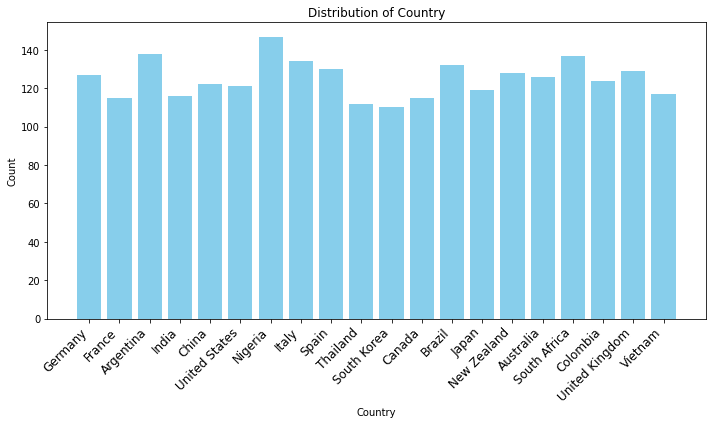

In [8]:
import matplotlib.pyplot as plt

# Compute the distribution of the "Country" variable
country_distribution = data.groupBy("Country").count()

country_distribution_local = country_distribution.toLocalIterator()

# Prepare data for plotting
countries = []
counts = []
for row in country_distribution_local:
    countries.append(row["Country"])
    counts.append(row["count"])

# Plot the bar graph
plt.figure(figsize=(10, 6))
plt.bar(countries, counts, color='skyblue')
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Distribution of Country')
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels and align to the right
plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()

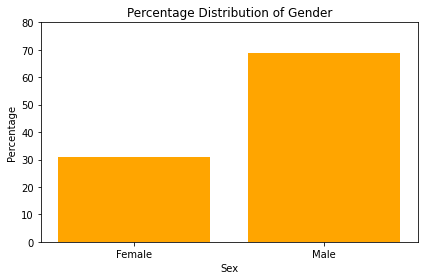

In [9]:
from pyspark.sql.functions import col

# Compute the distribution of the "Gender" variable
gender_distribution = data.groupBy("Sex").count()

# Compute the total count
total_count = data.count()

# Compute the percentage distribution
gender_percentage = gender_distribution.withColumn("Percentage", (col("count") / total_count) * 100)


gender_percentage_local = gender_percentage.collect()

# Prepare data for plotting
genders = [row["Sex"] for row in gender_percentage_local]
percentages = [row["Percentage"] for row in gender_percentage_local]

# Plot the percentage distribution
plt.bar(genders, percentages, color='orange')
plt.xlabel('Sex')
plt.ylabel('Percentage')
plt.title('Percentage Distribution of Gender')
plt.ylim(0, 80)  # Set y-axis limits to 0-100%
plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()

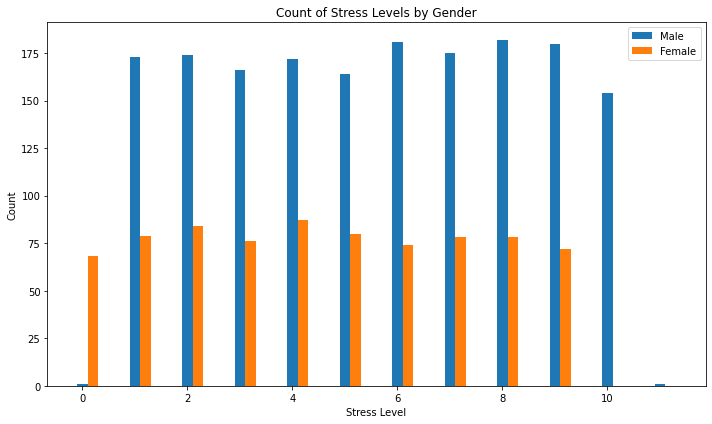

In [10]:
# Compute the count of stress levels for each gender
count_stress_by_gender = data.groupBy("Sex", "Stress Level").count().orderBy("Sex", "Stress Level")

# Collect data locally for plotting
count_stress_by_gender_local = count_stress_by_gender.collect()

# Prepare data for plotting
genders = list(set(row["Sex"] for row in count_stress_by_gender_local))
stress_levels = sorted(set(row["Stress Level"] for row in count_stress_by_gender_local if row["Stress Level"] is not None))
count_matrix = [[row["count"] for row in count_stress_by_gender_local if row["Sex"] == gender] for gender in genders]

# Get the maximum count of stress levels across genders
max_count = max(len(counts) for counts in count_matrix)

# Pad count_matrix with zeros if the count of stress levels is not consistent across genders
count_matrix_padded = [counts + [0] * (max_count - len(counts)) for counts in count_matrix]

# Plot the count of stress levels by gender
plt.figure(figsize=(10, 6))
for i, gender in enumerate(genders):
    plt.bar([x + i * 0.2 for x in range(max_count)], count_matrix_padded[i], width=0.2, label=gender)
plt.xlabel('Stress Level')
plt.ylabel('Count')
plt.title('Count of Stress Levels by Gender')
#plt.xticks([x  + bar_width/ 2 for x in range(len(stress_levels))], stress_levels)
plt.legend()
plt.tight_layout()
plt.show()

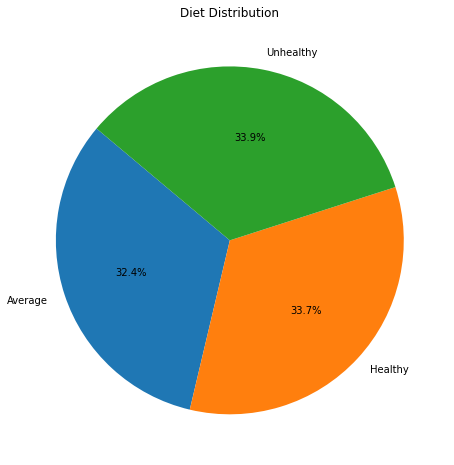

In [11]:
# Group the DataFrame by "Diet" and count the occurrences
diet_counts = data.groupBy("Diet").count().orderBy("Diet")


diet_counts_local = diet_counts.collect()

# Prepare data for plotting
diets = [row["Diet"] for row in diet_counts_local]
counts = [row["count"] for row in diet_counts_local]

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=diets, autopct='%1.1f%%', startangle=140)
plt.title('Diet Distribution')
plt.show()

## Verify Data Quality

In [12]:
from pyspark.sql.functions import col, sum as spark_sum

# List of columns to check for missing values
columns = data.columns

# Create a DataFrame to store the count of missing values for each column
missing_values = data.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in columns])

# Filter columns with missing values
missing_columns = missing_values.columns
missing_columns_with_values = [col_name for col_name in missing_columns if missing_values.select(col_name).head()[col_name] > 0]

# Create a new DataFrame with columns that have missing values
missing_values_filtered = missing_values.select(*missing_columns_with_values)

# Show the count of missing values for columns with missing values
missing_values_filtered.show()

+-----------------------+------------+-----------------------+---+-------------------+
|Exercise Hours Per Week|Stress Level|Sedentary Hours Per Day|BMI|Sleep Hours Per Day|
+-----------------------+------------+-----------------------+---+-------------------+
|                      3|           1|                      2|  3|                  2|
+-----------------------+------------+-----------------------+---+-------------------+



In [23]:
from pyspark.sql.types import IntegerType, DoubleType, StructType, StructField, StringType

# Function to calculate outliers for a column
def calculate_outliers(data, column):
    # Calculate Q1 and Q3
    quantiles = data.approxQuantile(column, [0.25, 0.75], 0.01)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter outliers
    outliers = data.filter((col(column) < lower_bound) | (col(column) > upper_bound))
    outlier_count = outliers.count()
    
    return outlier_count

# List to store outlier counts
outlier_counts = []

# Iterate through each column
for column in data.columns:
    # Check if the column is of numeric type (integer or double)
    if isinstance(data.schema[column].dataType, (IntegerType, DoubleType)):
        outlier_count = calculate_outliers(data, column)
        if outlier_count > 0:
            outlier_counts.append((column, outlier_count))

# Define schema for the results DataFrame
schema = StructType([
    StructField("Column", StringType(), True),
    StructField("Outlier Count", IntegerType(), True)
])

# Create DataFrame from the results
outlier_df = spark.createDataFrame(outlier_counts, schema)

# Show the results in tabular format
outlier_df.show(truncate=False)


+-----------------------+-------------+
|Column                 |Outlier Count|
+-----------------------+-------------+
|Heart Rate             |1            |
|Smoking                |276          |
|Exercise Hours Per Week|1            |
|Stress Level           |1            |
|Sleep Hours Per Day    |1            |
+-----------------------+-------------+



In [24]:
# Perform value counts for the variable "Gender"
value_counts1 = data.groupBy("Smoking").count()

# Show the value counts
value_counts1.show()

+-------+-----+
|Smoking|count|
+-------+-----+
|      1| 2223|
|      0|  276|
+-------+-----+



In [28]:
# Function to find extreme values for a column
def find_extreme_values(data, column):
    # Calculate Q1 and Q3
    quantiles = data.approxQuantile(column, [0.25, 0.75], 0.01)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter extreme values
    extreme_values_df = data.filter((col(column) < lower_bound) | (col(column) > upper_bound))
    return extreme_values_df

exclude_columns = ["Smoking"]

# Iterate through each column and find extreme values if the column is numeric
for column in data.columns:
    if column not in exclude_columns and isinstance(data.schema[column].dataType, (IntegerType, DoubleType)):
        extreme_values_df = find_extreme_values(data, column)
        if extreme_values_df.count() > 0:
            extreme_value = extreme_values_df.select(column).head()[0]
            print(f"{column} has an extreme value: {extreme_value}")

Heart Rate has an extreme value: 200
Exercise Hours Per Week has an extreme value: 40.546388
Stress Level has an extreme value: 20
Sleep Hours Per Day has an extreme value: 20
